This project comprises three blocks, 1. camera calibration. 2. Image Pipeline 3 video generation.

In [9]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

/Users/Antoni/anaconda/envs/tensorflow/lib/python3.5/site-packages/matplotlib/__init__.py:1120: UserWarning: Bad val "TkAgg or echo backend : Agg" on line #1
	"backend : TkAgg or echo backend : Agg
"
	in file "/Users/Antoni/.matplotlib/matplotlibrc"
	Key backend: Unrecognized backend string "tkagg or echo backend : agg": valid strings are ['Qt4Agg', 'template', 'WXAgg', 'agg', 'gdk', 'pdf', 'pgf', 'svg', 'TkAgg', 'MacOSX', 'WX', 'Qt5Agg', 'ps', 'GTKAgg', 'nbAgg', 'cairo', 'GTKCairo', 'GTK', 'WebAgg', 'GTK3Cairo', 'GTK3Agg']
  (val, error_details, msg))


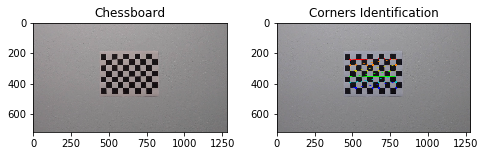

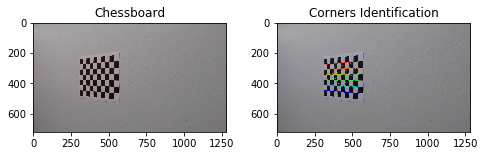

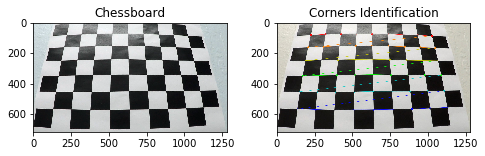

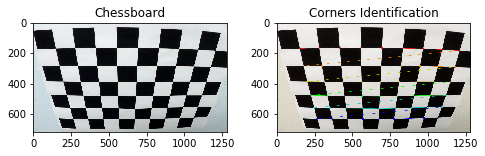

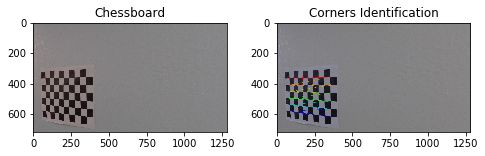

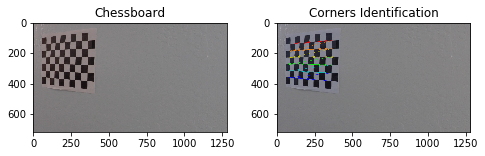

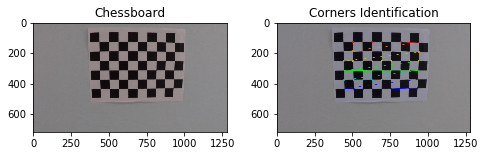

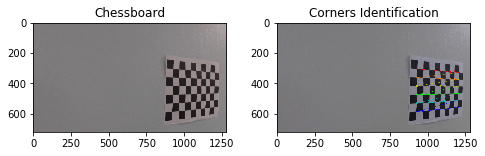

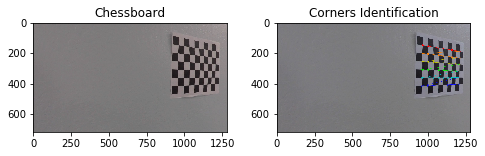

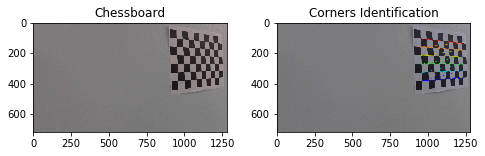

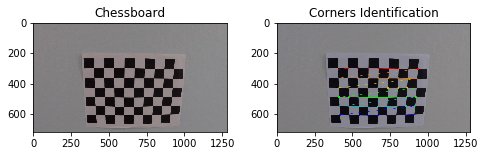

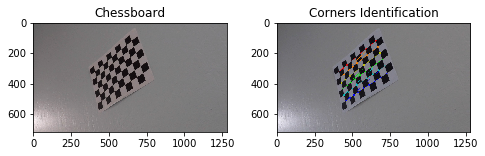

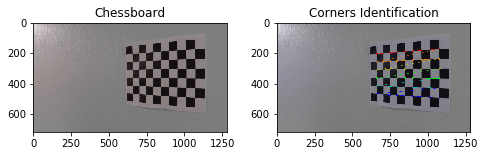

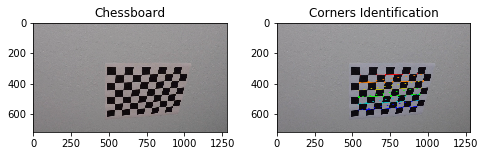

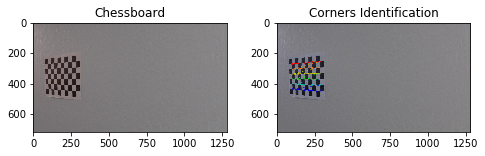

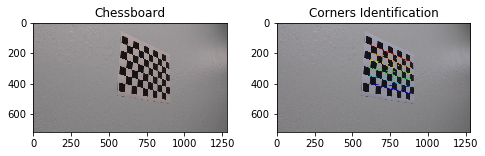

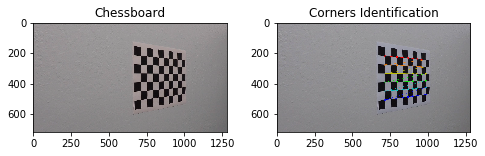

In [10]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
#list of images
calib_images = glob.glob('camera_cal/calibration*.jpg')
# two image samples
test1 = 'camera_cal/calibration9.jpg'
test2 = 'camera_cal/calibration11.jpg'
'''
# check two sample pictures. 
img = mpimg.imread(test1)
image_shape = img.shape
print(image_shape)
plt.figure()
plt.imshow(img)

img = mpimg.imread(test2)
image_shape = img.shape
print(image_shape)
plt.figure()
plt.imshow(img)
'''
# iterate through the 
for idx, image in enumerate(calib_images):
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,2))
        ax1.imshow(cv2.cvtColor(mpimg.imread(image), cv2.COLOR_BGR2RGB))
        ax1.set_title('Chessboard', fontsize=12)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Corners Identification', fontsize=12)

Apply the `undistort()` function to readjust camera based on the chessboard corner identification

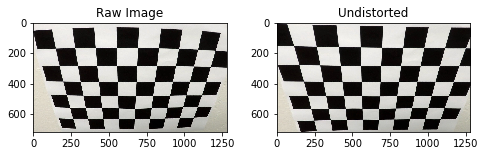

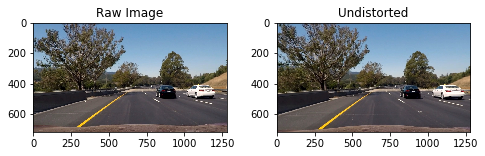

In [11]:


# Remove distortion from images
def undistort(image, show=True, read = True):
    if read:
        img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,2))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Raw Image', fontsize=12)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted', fontsize=12)
    else:
        return undist

# test using  a chessboard image
test_img = 'camera_cal/calibration2.jpg'
undistort(test_img)
# test using  a road image
test_img = 'test_images/test6.jpg'
undistort(test_img)

Now what I need to do is to `warp()` the image so that it shows a bird view picture from the front camera image. 

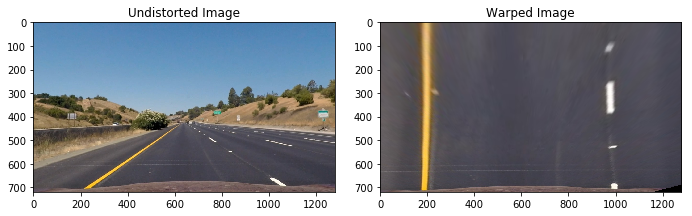

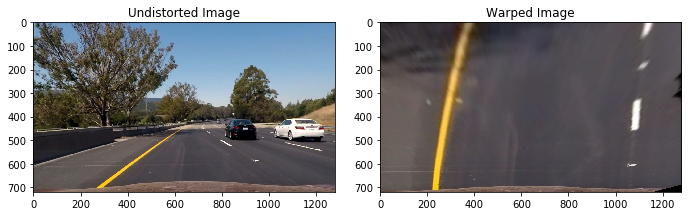

In [12]:
def warp(img, display=True, read = True):
    if read:
        undist = undistort(img, show = False)
    else:
        undist = undistort(img, show = False, read=False) 
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    
    
    # Assign anker points for perspective transform
    # my goal here is to pick up points that transfer strait roads lood like a rectangular in the warped image. 
    src_b_l = [220,720]
    src_b_r = [1110, 720]
    src_t_l = [571, 468]
    src_t_r = [720, 468]

    dst_b_l = [200,720]
    dst_b_r = [1000, 720]
    dst_t_l = [200, 0]
    dst_t_r = [1000, 0]
    
    
    src = np.float32([src_t_l,src_t_r,
                      src_b_r,src_b_l])
    dst = np.float32([dst_t_l,dst_t_r,
                      dst_b_r,dst_b_l])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=12)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Warped Image', fontsize=12)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M
    


# test using  a road image
test_img = 'test_images/straight_lines1.jpg'
warp(test_img)    
test_img = 'test_images/test6.jpg'
warp(test_img)    

In this section, I am implementing image filtering based on different `color spaces` and `color gradient`. The goal is to identify the contraction between the lane lines and the rest of the images. 

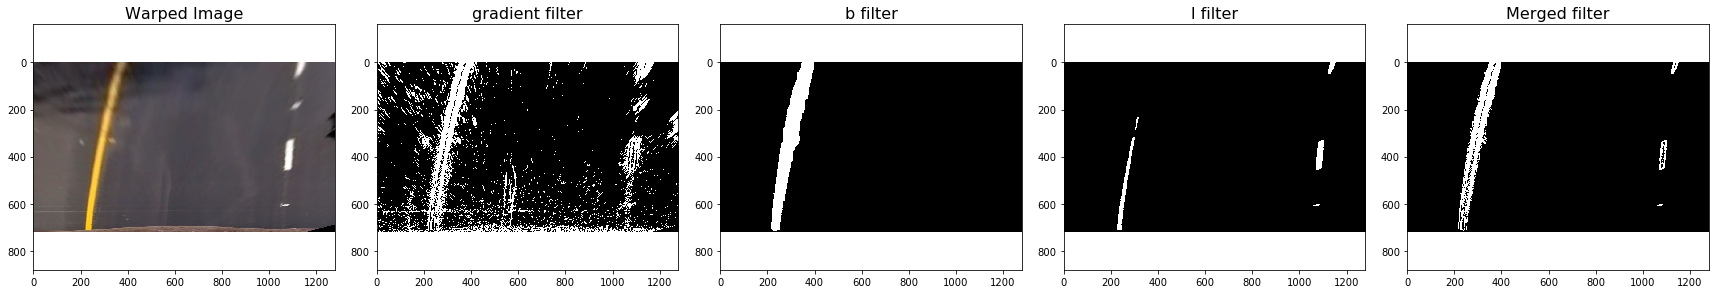

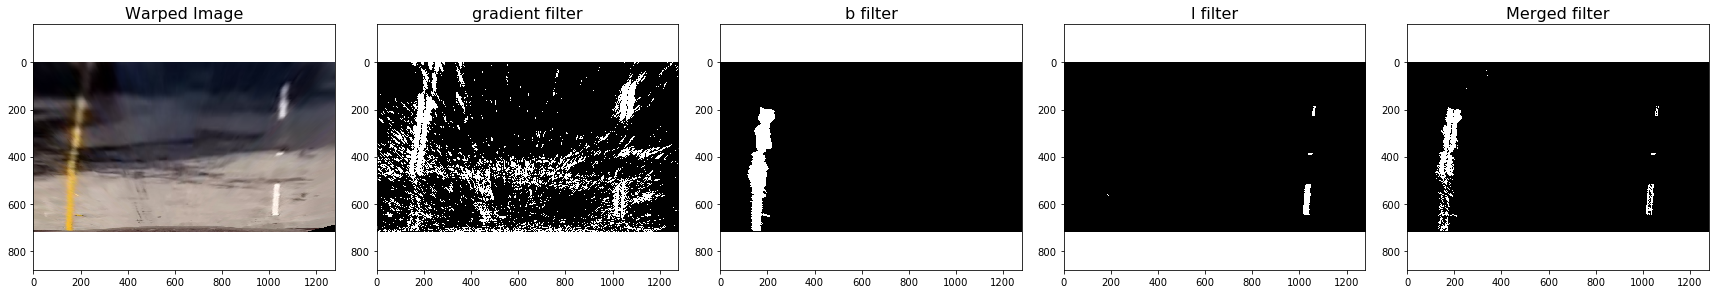

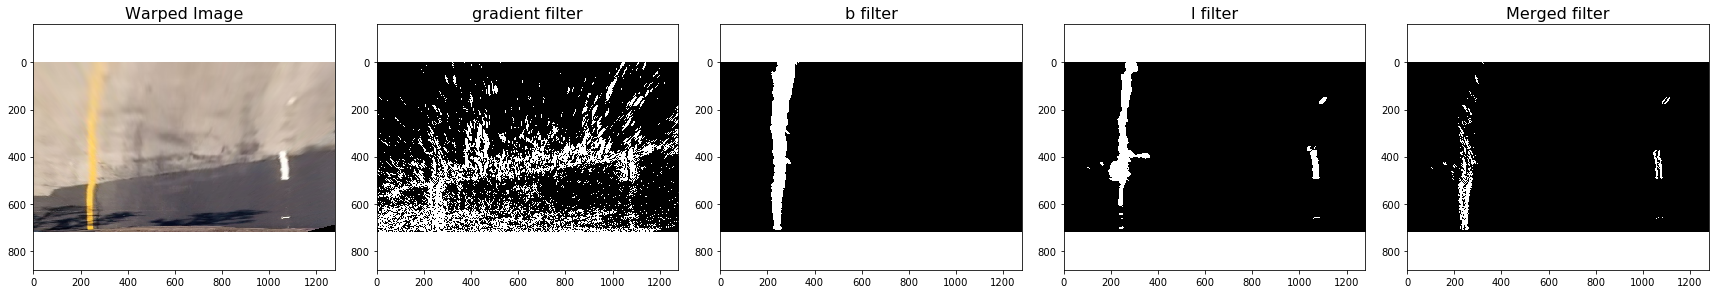

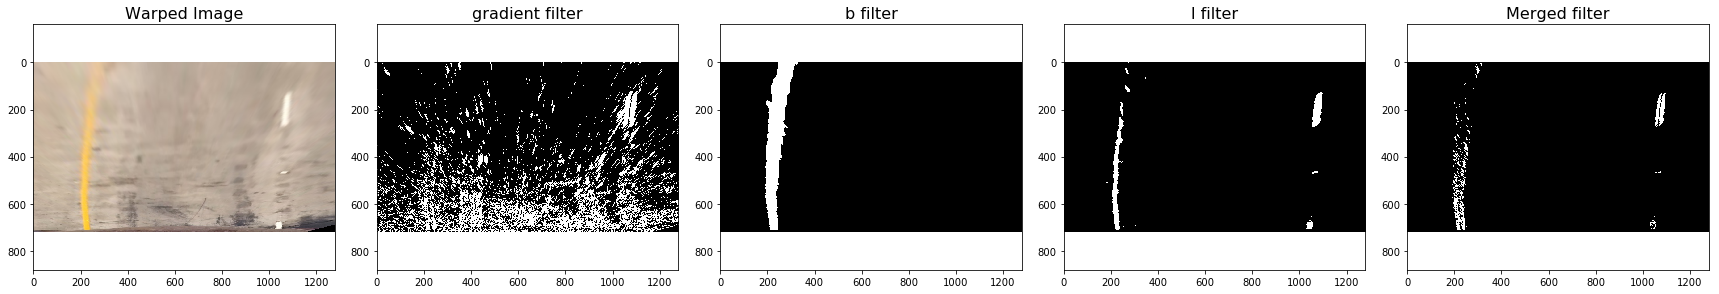

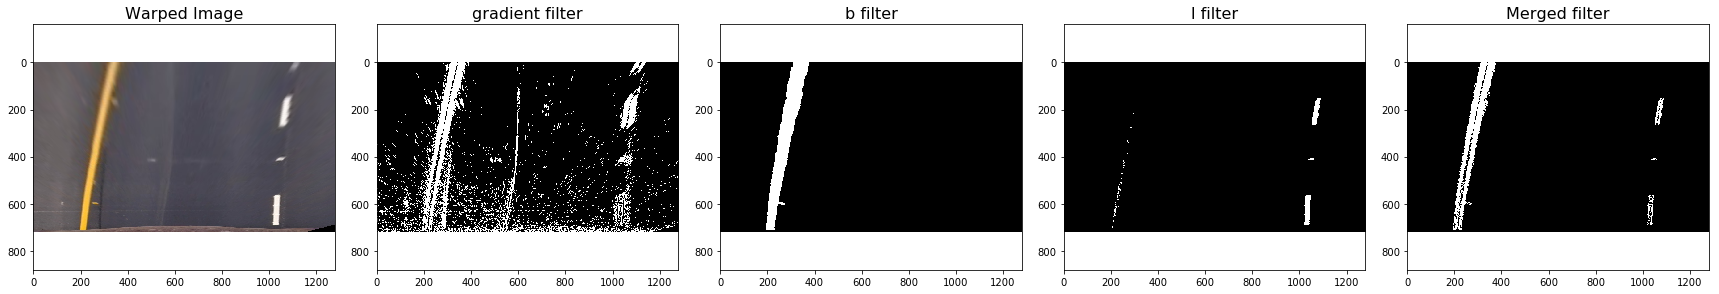

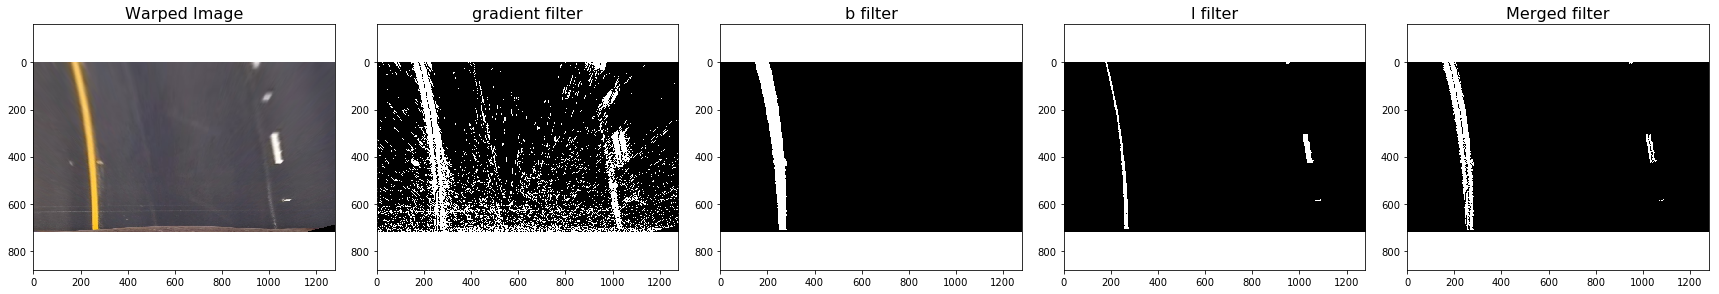

In [13]:
def filtering(image, show=True):
    img, M = warp(image, display = False)

    s = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    l = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Apply channel limits
    
    s_filter = np.zeros_like(s)
    s_filter[(s >= 200) & (s <= 255)] = 1
    
    l_filter = np.zeros_like(l)
    l_filter[(l >= 210) & (l <= 255)] = 1
    
    b_filter = np.zeros_like(b)
    b_filter[(b >= 146) & (b <= 255)] = 1
    
    #apply dradient limits
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sb_filter = np.zeros_like(scaled_sobel)
    sb_filter[(scaled_sobel >= 4) & (scaled_sobel <= 100)] = 1
    
    merged_filter = np.zeros_like(l_filter)
    merged_filter[((l_filter == 1) | (b_filter == 1) |(s_filter == 1))&(sb_filter==1)] = 1
    #merged_filter[((l_filter == 1) | (b_filter == 1))] = 1

    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3,ax4,ax5)) = plt.subplots(1,5, sharey='col', sharex='row', figsize=(24,4))
        f.tight_layout()
    
        ax1.set_title('Warped Image', fontsize=16)
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        ax2.set_title('gradient filter', fontsize=16)
        ax2.imshow(sb_filter, cmap='gray')
        ax3.set_title('b filter', fontsize=16)
        ax3.imshow(b_filter, cmap='gray')
        ax4.set_title('l filter', fontsize=16)
        ax4.imshow(l_filter, cmap='gray')
        ax5.set_title('Merged filter', fontsize=16)
        ax5.imshow(merged_filter, cmap='gray')
        
        
    else: 
        return merged_filter
    
for image in glob.glob('test_images/test*.jpg'):
    filtering(image)

Fine lane lines and calculate the radius.

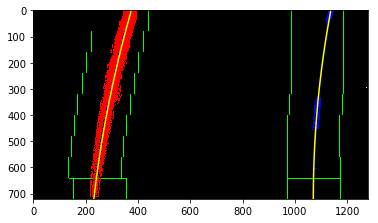

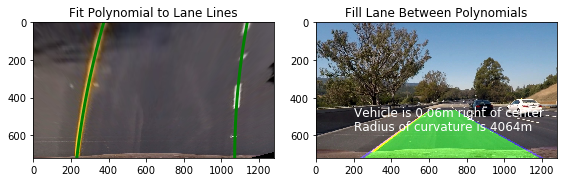

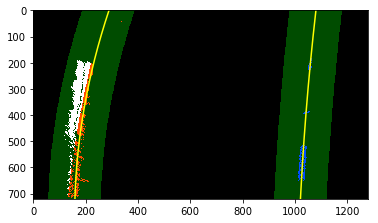

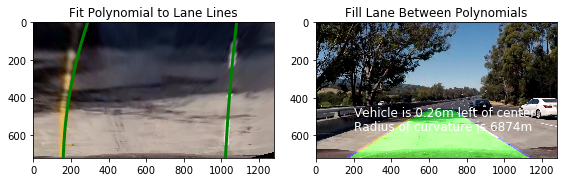

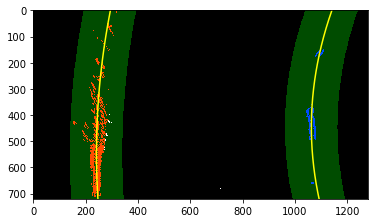

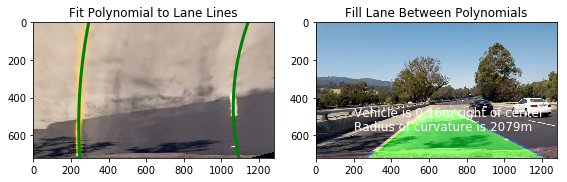

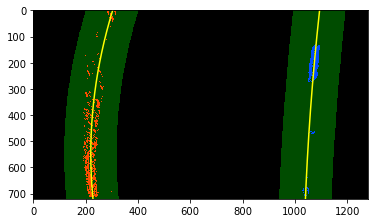

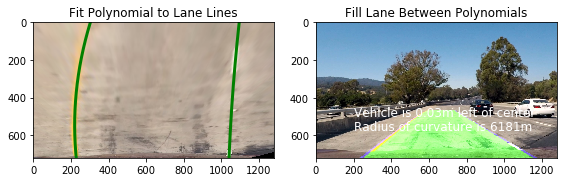

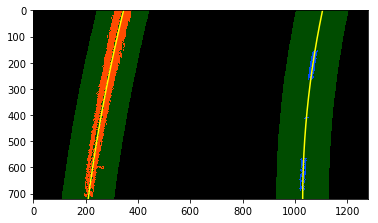

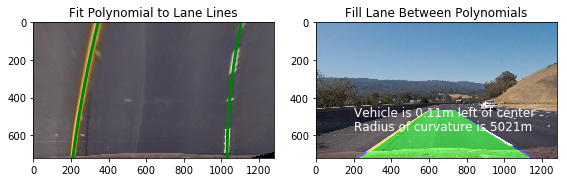

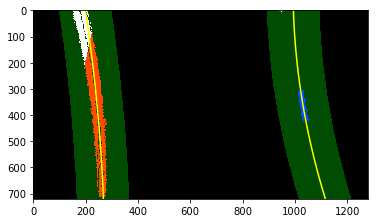

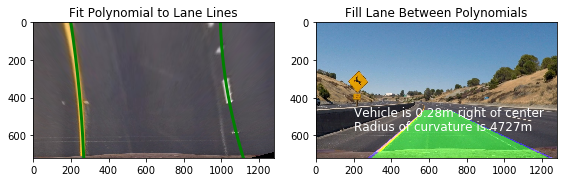

In [229]:
def find_lane(image,left_fit=None,right_fit=None,left_lane_inds=None, right_lane_inds=None,show=True):
    binary_warped = filtering(image,show=False)
    if left_lane_inds == None or right_lane_inds ==None:
        # Filter the lane line
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        if show==True:
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            plt.figure()
            plt.imshow(out_img)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
        
    # if already have lane detected, search nearby
    else:
        
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        if show==True:
            # Create an image to draw on and an image to show the selection window
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                          ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                          ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            plt.figure()
            plt.imshow(result)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            
# Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = left_fit
    right_fit_cr = right_fit
    
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(ploty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(ploty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    

    
    # Calculate the position of the vehicle
    rightx_bottom = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    leftx_bottom = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    center = (rightx_bottom+leftx_bottom)/2
    distance_from_center= abs(640 - center)
    
    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    
    src_b_l = [220,720]
    src_b_r = [1110, 720]
    src_t_l = [571, 468]
    src_t_r = [720, 468]

    dst_b_l = [200,720]
    dst_b_r = [1000, 720]
    dst_t_l = [200, 0]
    dst_t_r = [1000, 0]
    src = np.float32([src_t_l,src_t_r,
                      src_b_r,src_b_l])
    dst = np.float32([dst_t_l,dst_t_r,
                      dst_b_r,dst_b_l])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 4))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor((warp(image, display=False)[0]), cv2.COLOR_BGR2RGB))
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    
    ax1.plot(left_fitx, ploty, color='green', linewidth=3)
    ax1.plot(right_fitx, ploty, color='green', linewidth=3)
    ax1.set_title('Fit Polynomial to Lane Lines', fontsize=12)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(result)
    ax2.set_title('Fill Lane Between Polynomials', fontsize=12)
    if center < 640:
        ax2.text(200, 500, 'Vehicle is {:.2f}m left of center'.format(distance_from_center*3.7/700),
                 color='white', fontsize=12)
    else:
        ax2.text(200, 500, 'Vehicle is {:.2f}m right of center'.format(distance_from_center*3.7/700),
                 color='white', fontsize=12)
    ax2.text(200, 575, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),
             color='white', fontsize=12)            
    
        
    return left_fit,right_fit,list(left_lane_inds),list(right_lane_inds)

left_lane_inds=None
right_lane_inds=None  
left_fit=[]
right_fit=[]
for image in glob.glob('test_images/test*.jpg'):
    
    left_fit,right_fit,left_lane_inds,right_lane_inds = \
    find_lane(image,left_fit,right_fit,left_lane_inds,right_lane_inds )
    #print(left_lane_inds)
    #left_lane_inds,right_lane_inds=find_lane(image,left_lane_inds,right_lane_inds)    
    

### Lights, Camera, Action. 
Now it is time to turn on the video recording. The `line` class includes frames of the from camera, bird_view of the lane detection, estimation of the lane radius and the relative vehicle posistion. 

In [15]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    

In [235]:
# Video Processing Pipeline
def record_vid(image):
    img_size = (image.shape[1], image.shape[0])
    
    ### undistort
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    ### perspective transform
    offset = 0
    src_b_l = [220,720]
    src_b_r = [1110, 720]
    src_t_l = [571, 468]
    src_t_r = [720, 468]
    dst_b_l = [200,720]
    dst_b_r = [1000, 720]
    dst_t_l = [200, 0]
    dst_t_r = [1000, 0]
    src = np.float32([src_t_l,src_t_r,
                      src_b_r,src_b_l])
    dst = np.float32([dst_t_l,dst_t_r,
                      dst_b_r,dst_b_l])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    ### apply filter
    s = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)[:,:,2]
    l = cv2.cvtColor(warped, cv2.COLOR_BGR2LUV)[:,:,0]
    b = cv2.cvtColor(warped, cv2.COLOR_BGR2Lab)[:,:,2]   
    # Apply channel limits
    s_filter = np.zeros_like(s)
    s_filter[(s >= 200) & (s <= 255)] = 1
    l_filter = np.zeros_like(l)
    l_filter[(l >= 210) & (l <= 255)] = 1    
    b_filter = np.zeros_like(b)
    b_filter[(b >= 146) & (b <= 255)] = 1
    #apply dradient limits
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sb_filter = np.zeros_like(scaled_sobel)
    sb_filter[(scaled_sobel >= 4) & (scaled_sobel <= 100)] = 1
    merged_filter = np.zeros_like(l_filter)
    merged_filter[((l_filter == 1) | (b_filter == 1) |(s_filter == 1))&(sb_filter==1)] = 1  
    
    
    # Plotting thresholded images
    '''
    f, ((ax1, ax2, ax3,ax4,ax5)) = plt.subplots(1,5, sharey='col', sharex='row', figsize=(24,4))
    f.tight_layout()

    ax1.set_title('Warped Image', fontsize=16)
    ax1.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB).astype('uint8'))
    ax2.set_title('gradient filter', fontsize=16)
    ax2.imshow(sb_filter, cmap='gray')
    ax3.set_title('b filter', fontsize=16)
    ax3.imshow(b_filter, cmap='gray')
    ax4.set_title('l filter', fontsize=16)
    ax4.imshow(l_filter, cmap='gray')
    ax5.set_title('Merged filter', fontsize=16)
    ax5.imshow(merged_filter, cmap='gray')
    '''
    
        
    
    # Identify all non zero pixels in the image
    binary_warped = merged_filter
    nonzero = binary_warped.nonzero()
    
    y = np.array(nonzero[0])
    x = np.array(nonzero[1])
    
    if Left.detected == True: #
        margin = 100
        left_lane_inds = ((x > (Left.current_fit[0]*(y**2) + Left.current_fit[1]*y + 
        Left.current_fit[2] - margin)) & (x < (Left.current_fit[0]*(y**2) + 
        Left.current_fit[1]*y + Left.current_fit[2] + margin))) 

        leftx = x[left_lane_inds]
        lefty = y[left_lane_inds] 
        if np.sum(leftx) == 0: 
            Left.detected= False 
        else:
            Left.allx = leftx
            Left.ally = lefty
            Left.current_fit = np.polyfit(lefty, leftx, 2)
            # best fit averages over 10 samples
            if np.all(Left.best_fit)!=None:
                Left.best_fit = Left.best_fit *0.9 + Left.current_fit * 0.1
            else:
                Left.best_fit = Left.current_fit
            
    if Right.detected == True: # 
        margin = 100
        right_lane_inds = ((x > (Right.current_fit[0]*(y**2) + Right.current_fit[1]*y + 
        Right.current_fit[2] - margin)) & (x < (Right.current_fit[0]*(y**2) + 
        Right.current_fit[1]*y + Right.current_fit[2] + margin))) 

        rightx = x[right_lane_inds]
        righty = y[right_lane_inds] 
        
        if np.sum(rightx) == 0: 
            Right.detected= False 
        else:
            Right.allx = rightx
            Right.ally = righty
            Right.current_fit = np.polyfit(righty, rightx, 2)
            if np.all(Right.best_fit)!=None:
                Right.best_fit = Right.best_fit *0.9 + Right.current_fit * 0.1
            else:
                Right.best_fit = Right.current_fit
            
    if Left.detected == False: # Perform blind search for right lane lines
        # Filter the lane line
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        #print(midpoint)
        leftx_base = np.argmax(histogram[:midpoint])

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((y >= win_y_low) & (y < win_y_high) & 
            (x >= win_xleft_low) &  (x < win_xleft_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(x[good_left_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        #print(left_lane_inds)
        # Extract left and right line pixel positions
        leftx = x[left_lane_inds]
        lefty = y[left_lane_inds]
        
        if np.sum(leftx) > 0: 
            Left.detected= True 
            Left.allx = leftx
            Left.ally = lefty
            left_fit = np.polyfit(lefty, leftx, 2)
            Left.current_fit = left_fit
            if np.all(Left.best_fit)!=None:
                Left.best_fit = Left.best_fit *0.9 + Left.current_fit * 0.1
            else:
                Left.best_fit = Left.current_fit
        else:
            # reuse old data from 
            Left.detected= False

        # Fit a second order polynomial to each
        
            
    if Right.detected == False:# Perform blind search for left lane lines
        # Filter the lane line
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        #print(rightx_base)
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        
        # Current positions to be updated for each window
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_right_inds = ((y >= win_y_low) & (y < win_y_high) & 
            (x >= win_xright_low) &  (x < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(x[good_right_inds]))
        # Concatenate the arrays of indices
        right_lane_inds = np.concatenate(right_lane_inds)
        # Extract left and right line pixel positions
        rightx = x[right_lane_inds]
        righty = y[right_lane_inds]
        #print(rightx)
        if np.sum(rightx) > 0: 
            Right.detected= True 
            Right.allx = rightx
            Right.ally = righty

            right_fit = np.polyfit(righty, rightx, 2)
            Right.current_fit = right_fit
            if np.all(Right.best_fit)!=None:
                Right.best_fit = Right.best_fit *0.9 + Right.current_fit * 0.1
            else:
                Right.best_fit = Right.current_fit
        else:
            Right.detected= False

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    
    
    
    # x values of the last n fits of the line
    if np.all(Left.allx) !=None:
        Left.recent_xfitted.extend(Left.allx) 
        #average x values of the fitted line over the last n iterations
        Left.bestx = np.mean(Left.recent_xfitted) 
    
    # x values of the last n fits of the line
    if np.all(Right.allx) !=None:
        Right.recent_xfitted.extend(Right.allx) 
        #average x values of the fitted line over the last n iterations
        Right.bestx = np.mean(Right.recent_xfitted) 
     
    if len(Right.recent_xfitted)>90:
        Right.recent_xfitted = Right.recent_xfitted[-90:]
    if len(Left.recent_xfitted)>90:
        Left.recent_xfitted = Left.recent_xfitted[-90:]
          
    #radius of curvature of the line in some units
    
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = Left.current_fit
    right_fit_cr = Right.current_fit
    
    # Calculate left and right fit points
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )  
    left_fitx = Left.current_fit[0]*ploty**2 + Left.current_fit[1]*ploty + Left.current_fit[2]
    right_fitx = Right.current_fit[0]*ploty**2 + Right.current_fit[1]*ploty + Right.current_fit[2]
       
    
    # Calculate the new radius of curvature
    Left.radius_of_curvature = ((1 + (2*left_fit_cr[0]*np.max(ploty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    Right.radius_of_curvature = ((1 + (2*right_fit_cr[0]*np.max(ploty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    #distance in meters of vehicle center from the line
    rightx_bottom = Right.current_fit[0]*720**2 + Right.current_fit[1]*720 + Right.current_fit[2]
    leftx_bottom = Left.current_fit[0]*720**2 + Left.current_fit[1]*720 + Left.current_fit[2]
    
    center = (rightx_bottom+leftx_bottom)/2
    distance_from_center = abs(640 - ((rightx_bottom+leftx_bottom)/2))
       
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(merged_filter).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    #print(result)
    ''' 
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 4))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    
    ax1.plot(left_fitx, ploty, color='green', linewidth=3)
    ax1.plot(right_fitx, ploty, color='green', linewidth=3)
    ax1.set_title('Fit Polynomial to Lane Lines', fontsize=12)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(result)
    ax2.set_title('Fill Lane Between Polynomials', fontsize=12)
    if center < 640:
        ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(distance_from_center*xm_per_pix),
                 color='white', fontsize=12)
    else:
        ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(distance_from_center*xm_per_pix),
                 color='white', fontsize=12)
    ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((Left.radius_of_curvature+Right.radius_of_curvature)/2)),
             color='white', fontsize=12)   
    '''
    # Print distance from center on video
    
    if center < 640:
        cv2.putText(result, \
                    'Vehicle is {:.2f}m left of center'.format(distance_from_center*xm_per_pix), \
                    (200,100), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, \
                    'Vehicle is {:.2f}m right of center'.format(distance_from_center*xm_per_pix), \
                    (200,100), fontFace = cv2.FONT_HERSHEY_SIMPLEX,   fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, \
                'Radius of Curvature {}(m)'.format(int((Left.radius_of_curvature+Right.radius_of_curvature)/2)),\
                (200,175), fontFace = cv2.FONT_HERSHEY_SIMPLEX,   fontScale = 2,color=(255,255,255), thickness = 2)
    
    return result

In [240]:
Left = Line()
Right = Line()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,2)
white_clip = clip1.fl_image(record_vid) 
white_clip.write_videofile(video_output, audio=False)
    

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [29:08<00:01,  1.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [241]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))